<a href="https://colab.research.google.com/github/DrAlexSanz/trigger/blob/master/Trigger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf "/content/trigger"

!git clone https://github.com/DrAlexSanz/trigger.git

Cloning into 'trigger'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 99 (delta 5), reused 0 (delta 0), pack-reused 84
Unpacking objects: 100% (99/99), done.


In [2]:
%cd "/content/trigger"

/content/trigger


In [3]:
!pip install pydub

In [0]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

For this exercise, our trigger word will be "Activate." Every time it hears you say "activate," it will make a "chiming" sound. By the end of this assignment, you will be able to record a clip of yourself talking, and have the algorithm trigger a chime when it detects you saying "activate". And now, a fancy word of a sound wave. It doesn't give anything else than the visuals, but it's nice.

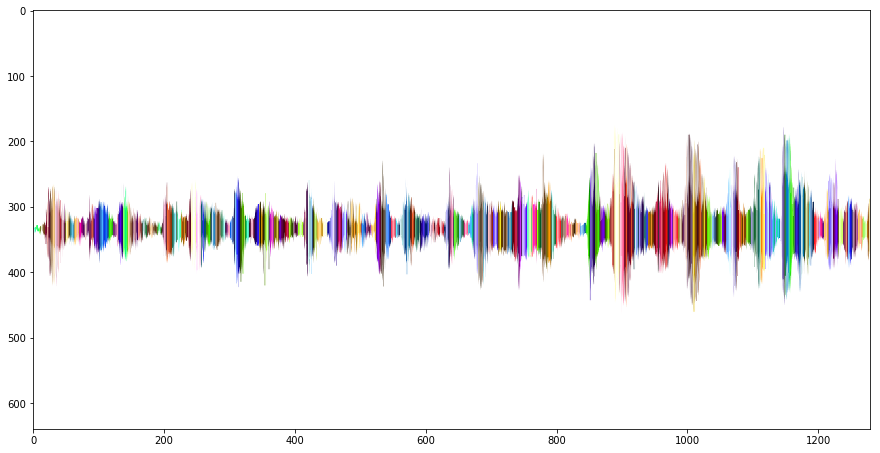

In [5]:
fancy_sound = plt.imread("images/sound.png")
plt.figure(figsize = (15, 12))

plt.imshow(fancy_sound)

# 1 - Data synthesis: Creating a speech dataset

Let's start by building a dataset for your trigger word detection algorithm. A speech dataset should ideally be as close as possible to the application you will want to run it on. In this case, you'd like to detect the word "activate" in working environments (library, home, offices, open-spaces ...). You thus need to create recordings with a mix of positive words ("activate") and negative words (random words other than activate) on different background sounds. Let's see how you can create such a dataset.

## 1.1 - Listening to the data

One of your friends is helping you out on this project, and they've gone to libraries, cafes, restaurants, homes and offices all around the region to record background noises, as well as snippets of audio of people saying positive/negative words. This dataset includes people speaking in a variety of accents.

In the raw_data directory, you can find a subset of the raw audio files of the positive words, negative words, and background noise. You will use these audio files to synthesize a dataset to train the model. The "activate" directory contains positive examples of people saying the word "activate". The "negatives" directory contains negative examples of people saying random words other than "activate". There is one word per audio recording. The "backgrounds" directory contains 10 second clips of background noise in different environments.

In [6]:
IPython.display.Audio("./raw_data/activates/1.wav")

In [7]:
IPython.display.Audio("./raw_data/negatives/3_2.wav")

In [8]:
IPython.display.Audio("./raw_data/backgrounds/2.wav")

## 1.2 - From audio recordings to spectrograms

What really is an audio recording? A microphone records little variations in air pressure over time, and it is these little variations in air pressure that your ear also perceives as sound. You can think of an audio recording is a long list of numbers measuring the little air pressure changes detected by the microphone. We will use audio sampled at 44100 Hz (or 44100 Hertz). This means the microphone gives us 44100 numbers per second. Thus, a 10 second audio clip is represented by 441000 numbers (= $10 \times 44100$).

It is quite difficult to figure out from this "raw" representation of audio whether the word "activate" was said. In order to help your sequence model more easily learn to detect triggerwords, we will compute a spectrogram of the audio. The spectrogram tells us how much different frequencies are present in an audio clip at a moment in time.

(If you've ever taken an advanced class on signal processing or on Fourier transforms, a spectrogram is computed by sliding a window over the raw audio signal, and calculates the most active frequencies in each window using a Fourier transform. If you don't understand the previous sentence, don't worry about it).



In [9]:
IPython.display.Audio("audio_examples/example_train.wav")

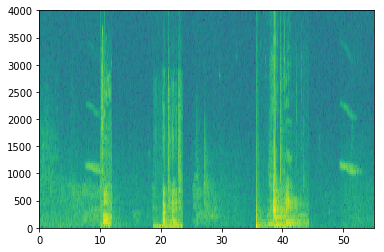

In [10]:
x = graph_spectrogram("audio_examples/example_train.wav")

The graph above represents a colour map to show how active each frequency is (Y-axis) over a number of time-steps (X-axis). They could have included this in the function. Just the axis

The dimension of the output spectrogram depends upon the hyperparameters of the spectrogram software and the length of the input. In this notebook, we will be working with 10 second audio clips as the "standard length" for our training examples. The number of timesteps of the spectrogram will be 5511. You'll see later that the spectrogram will be the input $x$ into the network, and so $T_x = 5511$.

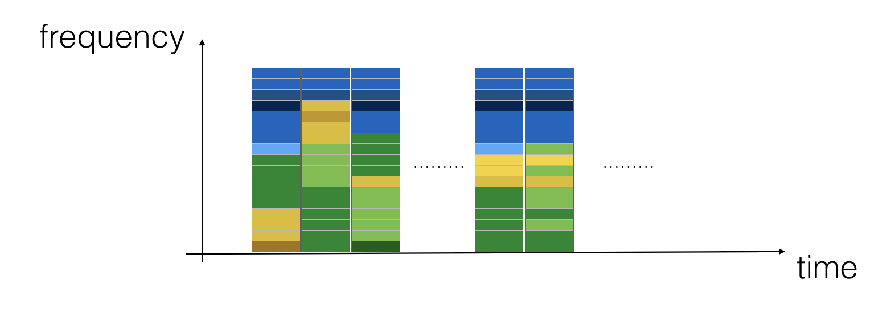

In [11]:
spec_concept = plt.imread("images/spectrogram.png")
plt.figure(figsize = (15, 12))
plt.axis("off")
plt.imshow(spec_concept)

In [12]:
_, data = wavfile.read("audio_examples/example_train.wav")

print("Time steps in audio file before spectrogram = ", data[:, 0].shape)
print("Time steps in input after spectrogram = ", x.shape)

Time steps in audio file before spectrogram =  (441000,)
Time steps in input after spectrogram =  (101, 5511)


Now define:

In [0]:
Tx = 5511 # The number of time steps in the input AFTER the spectrogram is created.
n_freq = 101 # The number of frequencies analyzed (output) for each time step by the spectrogram software.

Note that even with 10 seconds being our default training example length, 10 seconds of time can be discretized to different numbers of value. You've seen 441000 (raw audio) and 5511 (spectrogram). In the former case, each step represents $10/441000 \approx 0.000023$ seconds. In the second case, each step represents $10/5511 \approx 0.0018$ seconds.

For the 10sec of audio, the key values you will see in this assignment are:

$441000$ (raw audio)
$5511 = T_x$ (spectrogram output, and dimension of input to the neural network).
$10000$ (used by the pydub module to synthesize audio)
$1375 = T_y$ (the number of steps in the output of the GRU you'll build).
Note that each of these representations correspond to exactly 10 seconds of time. It's just that they are discretizing them to different degrees. All of these are hyperparameters and can be changed (except the 441000, which is a function of the microphone). We have chosen values that are within the standard ranges uses for speech systems.

Consider the $T_y = 1375$ number above. This means that for the output of the model, we discretize the 10s into 1375 time-intervals (each one of length $10/1375 \approx 0.0072$s) and try to predict for each of these intervals whether someone recently finished saying "activate."

Consider also the 10000 number above. This corresponds to discretizing the 10sec clip into 10/10000 = 0.001 second itervals. 0.001 seconds is also called 1 millisecond, or 1ms. So when we say we are discretizing according to 1ms intervals, it means we are using 10,000 steps.

In [0]:
Ty = 1375 # Number of time steps output by my model.

## 1.3 - Generating a single training example

Because speech data is hard to acquire and label, you will synthesize your training data using the audio clips of activates, negatives, and backgrounds. It is quite slow to record lots of 10 second audio clips with random "activates" in it. Instead, it is easier to record lots of positives and negative words, and record background noise separately (or download background noise from free online sources).

To synthesize a single training example, you will:

* Pick a random 10 second background audio clip
* Randomly insert 0-4 audio clips of "activate" into this 10sec clip
* Randomly insert 0-2 audio clips of negative words into this 10sec clip

Because you had synthesized the word "activate" into the background clip, you know exactly when in the 10sec clip the "activate" makes its appearance. You'll see later that this makes it easier to generate the labels $y^{\langle t \rangle}$ as well.

You will use the pydub package to manipulate audio. Pydub converts raw audio files into lists of Pydub data structures (it is not important to know the details here). Pydub uses 1ms as the discretization interval (1ms is 1 millisecond = 1/1000 seconds) which is why a 10sec clip is always represented using 10,000 steps.

In [15]:
# Load audios with pydub

activates, negatives, backgrounds = load_raw_audio()

print("Background length = ", len(backgrounds[0])) # Should be 10.000 because it's 10 s and I am using ms sampling.
print("(Approx) Activate [0] length = ", len(activates[0])) # Should be around 1000, "activate" lasts usually around 1 s.
print("(Approx) Activate [1] length = ", len(activates[1]))

Background length =  10000
(Approx) Activate [0] length =  1741
(Approx) Activate [1] length =  1579


### Overlaying positive/negative words on the background:

Given a 10sec background clip and a short audio clip (positive or negative word), you need to be able to "add" or "insert" the word's short audio clip onto the background. To ensure audio segments inserted onto the background do not overlap, you will keep track of the times of previously inserted audio clips. You will be inserting multiple clips of positive/negative words onto the background, and you don't want to insert an "activate" or a random word somewhere that overlaps with another clip you had previously added.

For clarity, when you insert a 1sec "activate" onto a 10sec clip of cafe noise, you end up with a 10sec clip that sounds like someone sayng "activate" in a cafe, with "activate" superimposed on the background cafe noise. You do not end up with an 11 sec clip. You'll see later how pydub allows you to do this.

### Creating the labels at the same time you overlay:

Recall also that the labels $y^{\langle t \rangle}$ represent whether or not someone has just finished saying "activate." Given a background clip, we can initialize $y^{\langle t \rangle}=0$ for all $t$, since the clip doesn't contain any "activates."

When you insert or overlay an "activate" clip, you will also update labels for $y^{\langle t \rangle}$, so that 50 steps of the output now have target label 1. You will train a GRU to detect when someone has finished saying "activate". For example, suppose the synthesized "activate" clip ends at the 5sec mark in the 10sec audio---exactly halfway into the clip. Recall that $T_y = 1375$, so timestep $687 = $ int(1375*0.5) corresponds to the moment at 5sec into the audio. So, you will set $y^{\langle 688 \rangle} = 1$. Further, you would quite satisfied if the GRU detects "activate" anywhere within a short time-internal after this moment, so we actually set 50 consecutive values of the label $y^{\langle t \rangle}$ to 1. Specifically, we have $y^{\langle 688 \rangle} = y^{\langle 689 \rangle} = \cdots = y^{\langle 737 \rangle} = 1$.

This is another reason for synthesizing the training data: It's relatively straightforward to generate these labels $y^{\langle t \rangle}$ as described above. In contrast, if you have 10sec of audio recorded on a microphone, it's quite time consuming for a person to listen to it and mark manually exactly when "activate" finished.

Here's a figure illustrating the labels $y^{\langle t \rangle}$, for a clip which we have inserted "activate", "innocent", activate", "baby." Note that the positive labels "1" are associated only with the positive words.

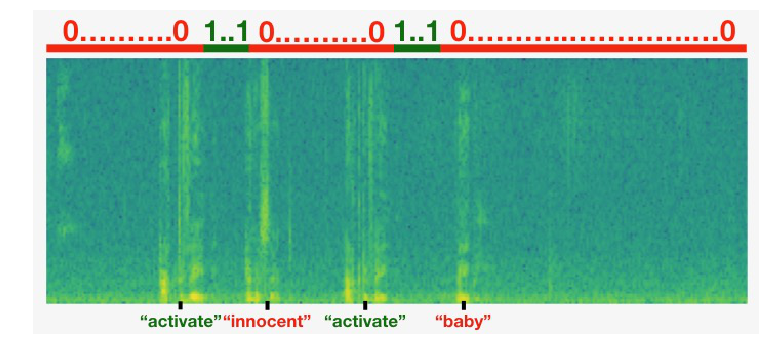

In [16]:
annot = plt.imread("images/label_diagram.png", 0) # Apparently there is something wrong with the image, try to infer it.

plt.figure(figsize = (13, 10))
plt.axis("off")
plt.imshow(annot)

To implement the training set synthesis process, you will use the following helper functions. All of these function will use a 1ms discretization interval, so the 10sec of audio is alwsys discretized into 10,000 steps.

* get_random_time_segment(segment_ms) gets a random time segment in our background audio
* is_overlapping(segment_time, existing_segments) checks if a time segment overlaps with existing segments
* insert_audio_clip(background, audio_clip, existing_times) inserts an audio segment at a random time in our background audio using get_random_time_segment and is_overlapping
* insert_ones(y, segment_end_ms) inserts 1's into our label vector y after the word "activate"
* get_random_time_segment(segment_ms) returns a random time segment onto which we can insert an audio clip of duration segment_ms.


In [0]:
def get_random_time_segment(segment_ms):
    """
    This function gets a random time segment in our background audio.
    
    Input: segment_ms is the duration of the audio clip in ms (1000 here)
    
    Output: segment_time, a tuple with (segment_start, segment_end) in ms.   
    
    """
    
    segment_start = np.random.randint(low = 0, high = 10000 - segment_ms)
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

Next, suppose you have inserted audio clips at segments (1000,1800) and (3400,4500). I.e., the first segment starts at step 1000, and ends at step 1800. Now, if we are considering inserting a new audio clip at (3000,3600) does this overlap with one of the previously inserted segments? In this case, (3000,3600) and (3400,4500) overlap, so we should decide against inserting a clip here.

For the purpose of this function, define (100,200) and (200,250) to be overlapping, since they overlap at timestep 200. However, (100,199) and (200,250) are non-overlapping.

In [0]:
def is_overlapping(segment_time, previous_segments):
    """
    This function takes the current segment where I will insert activate and check if it overlaps with another segment that I chose previously.
    
    Inputs: segment_time -> tuple (segment_start, segment_end) representing the current segment
            previous_segment -> list of tuples, the same format as above.
            
    Output: True if the segment overlaps with some other segment. False if it doesn't.
    """
    
    segment_start, segment_end = segment_time
    
    # First assume it doesn't overlap
    
    overlap = False
    
    # Compare times
    
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
    
    return overlap

Let's test this.

In [22]:
over_1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
over_2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])

print("Overlap 1 = ", over_1)
print("Overlap 2 = ", over_2)

Overlap 1 =  False
Overlap 2 =  True


Implement insert_audio_clip() to overlay an audio clip onto the background 10sec clip. You will need to carry out 4 steps:

1. Get a random time segment of the right duration in ms.
2. Make sure that the time segment does not overlap with any of the previous time segments. If it is overlapping, then go back to step 1 and pick a new time segment.
3. Add the new time segment to the list of existing time segments, so as to keep track of all the segments you've inserted.
4. Overlay the audio clip over the background using pydub. We have implemented this for you.

In [0]:
def insert_sound_clip(background, audio_clip, previous_segments):
    """
    This function overlays a new audio segment over the background clip (10 s).
    It checks that they are not overlapping.
    
    Input: background. A 10 s clip.
           audio_clip. The audio clip that I will insert.
           previous_segment. List of tuples, to call the previous function and check that nothing overlaps.
    
    Output: new_background. Updated background audio.
    """
    
    # Get the duration of the clip
    
    segment_ms = len(audio_clip)
    
    # Pick where to insert the audio clip
    
    segment_time = get_random_time_segment(segment_ms)
    
    # If it overlaps, keep picking new segments until I find a segment that is "available".
    while is_overlapping(segment_time, previous_segments) == True:
        segment_time = get_random_time_segment(segment_ms)
    
    # Add the new segment to previous_segments list
    
    previous_segments.append(segment_time)
    
    # Overlay the trigger word at the start of the picked segment.
    
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [28]:
np.random.seed(13)
audio_clip, segment_time = insert_sound_clip(backgrounds[0], activates[0], [(3790, 4400)])

audio_clip.export("insert_test.wav", format = "wav")
print("Segment time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Segment time:  (338, 2078)
